<a href="https://colab.research.google.com/github/slslslrhfem/AutoGeneration/blob/master/PPDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import pandas
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras.models import Sequential
midifilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi')
csvfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv')
jsonfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/descriptor')

In [ ]:
midifilenames=sorted(midifilenames)
csvfilenames=sorted(csvfilenames)
jsonfilenames=sorted(jsonfilenames)

In [ ]:
def get_meta(filename):
  with open('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/descriptor/'+filename) as json_file:
    meta_data = json.load(json_file)
  return meta_data

In [ ]:
pip install mido

     |████████████████████████████████| 61kB 1.8MB/s 


In [ ]:
pip install pretty_midi

In [ ]:
import pretty_midi
import mido
from tqdm import tqdm
import pickle
with open('/content/drive/My Drive/MARG/PPDDlist/midilist.txt', 'rb') as f:
  midilist=pickle.load(f)
with open('/content/drive/My Drive/MARG/PPDDlist/csvlist.txt', 'rb') as f2:
  csvlist=pickle.load(f2)
with open('/content/drive/My Drive/MARG/PPDDlist/jsonlist.txt', 'rb') as f3:
  jsonlist=pickle.load(f3)
with open('/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt', 'rb') as f4:
  prettymidilist=pickle.load(f4)

In [ ]:
import pretty_midi
import mido
from tqdm import tqdm
midilist=[]
csvlist=[]
jsonlist=[]
prettymidilist=[]
for filenames in tqdm(midifilenames,position=0):
  midi_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi/'+filenames
  mid = mido.MidiFile(midi_path, clip=True)
  midilist.append(mid)
  prettymid=pretty_midi.PrettyMIDI(midi_path)
  prettymidilist.append(prettymid)

for filenames in tqdm(csvfilenames,position=0):
  csv_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv/'+filenames
  csv = pandas.read_csv(csv_path)
  csvlist.append(csv)
for filenames in tqdm(jsonfilenames,position=0):
  jsonlist.append(get_meta(filenames))

#midifilenames와 list들의 순서는 같다고 생각하고 코드 작성

In [ ]:
import pickle
with open('/content/drive/My Drive/MARG/PPDDlist/midilist.txt', 'wb') as f:
  pickle.dump(midilist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/csvlist.txt', 'wb') as f:
  pickle.dump(csvlist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/jsonlist.txt', 'wb') as f:
  pickle.dump(jsonlist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt', 'wb') as f:
  pickle.dump(prettymidilist, f)

아래의 코드는 csv기반의 Processing을 진행한다. 
MIDI 기반의 Processing은 다음 블록에 작성되어 있으며, 둘 중 하나만 굴리면 된다.

In [ ]:
#현재 CSV dataset에 문제가 있어보인다..
bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
import numpy as np
for i,csvs in enumerate(tqdm(csvlist)):
  a=np.array([list(map(float,csvs.columns))])#column에도 숫자가 들어가 있어서.. 경우에 따라 조절한다
  b=np.array(csvs.values)
  csvarray=np.concatenate((a,b),axis=0)
  if('timeSignature' not in jsonlist[i]):
    jsonlist[i]['timeSignature']=[4,4]
  one_bar_number=jsonlist[i]['timeSignature'][0]
  bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
  bar_info_list=[]
  for i in range(int(bar_number)):
    starting_bar_time=csvarray[0][0]+i*one_bar_number
    bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])
  bar_list.append(bar_info_list)
  one_bar_number_list.append(one_bar_number)
  starting_number_list.append(csvarray[0][0])

In [ ]:
pip install pretty_midi

     |████████████████████████████████| 5.6MB 2.4MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=6a7920359801b3528ab5bfb706ddfb03e9d2e6088fade7cf67c5a4281515b87f
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
#이게 이제 input을 midi로 받는 코드.
import numpy as np
import pretty_midi
bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
for i,songs in enumerate(prettymidilist):#곡마다
  for instrument in songs.instruments: #2. 어차피 instrument하나
    csvarray=[]
    for note in instrument.notes: #3
      row=[note.start, note.pitch, note.pitch, note.end - note.start, 0]
      csvarray.append(row)
  csvarray=np.array(csvarray)
  if('timeSignature' not in jsonlist[i]):
    jsonlist[i]['timeSignature']=[4,4]
  one_bar_number=jsonlist[i]['timeSignature'][0]
  bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
  bar_info_list=[]
  for i in range(int(bar_number)):
    starting_bar_time=csvarray[0][0]+i*one_bar_number
    bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])
  bar_list.append(bar_info_list)
  one_bar_number_list.append(one_bar_number)
  starting_number_list.append(csvarray[0][0])

In [ ]:
for bars in bar_list:
  #print(len(bars))결과 보면 다 다르다. 따라서 정해진 Shape가 없음
  for matrix in bars:
    for lists in matrix:
      if (lists[1]<24):
        print(lists[1])#Small Data기준 95가 최대, 25가 Minimum. Big Data로 바꾸면 추가적인 조절 가능할듯

In [ ]:
print(bar_list[8][0])#1번째 곡의 1번째 bar.

[[ 0.25 59.   59.    0.25  0.  ]
 [ 0.5  62.   62.    0.25  0.  ]
 [ 0.75 59.   59.    0.25  0.  ]
 [ 1.   62.   62.    0.25  0.  ]
 [ 1.25 59.   59.    0.25  0.  ]
 [ 1.5  55.   55.    0.25  0.  ]
 [ 1.75 59.   59.    0.25  0.  ]
 [ 2.   63.   63.    0.25  0.  ]
 [ 2.25 59.   59.    0.25  0.  ]
 [ 2.5  63.   63.    0.25  0.  ]
 [ 2.75 59.   59.    0.25  0.  ]
 [ 3.   55.   55.    0.25  0.  ]
 [ 3.25 59.   59.    0.25  0.  ]
 [ 3.5  62.   62.    0.25  0.  ]
 [ 3.75 59.   59.    0.25  0.  ]
 [ 4.   62.   62.    0.25  0.  ]]


In [ ]:
print(bar_info_list)# bar info list가 bar마다 csv내용들 담겨져 있는거다.

In [ ]:
def nearest_time(time,minimum_size):
  #혹시나 값이 조금 벗어나는 엇박 음을 가까운 최소단위로 Shifting한다.
  #다만 엇박 관련 Skill Detecting을 따로 고려할시 코드를 수정할 수 있다.
  num_to_multiply=time/minimum_size
  num_to_multiply=int(num_to_multiply)
  left_time=num_to_multiply*minimum_size
  right_time=left_time+minimum_size
  if (time-left_time>=right_time-time):
    return right_time
  return left_time
def bar_to_matrix1(bar,one_bar_number,starting_number,i):
  #그냥 점만 남긴다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.
  #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
  init=np.zeros((112,96))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/96
  zero_time=starting_number+one_bar_number*i    
  for j,lists in enumerate(bar):
    
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    if(point==96):
      point=92
    
    init[111-int(lists[1])][point]=lists[3]#111-int(list[1])형태로 해야 직관적인 PianoRoll 형태가 ㅏ온다.
  return init
def bar_to_matrix2(bar,one_bar_number,starting_number,i):
  #Duration에 따라 Ploting한다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.

  init=np.zeros((112,96))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/96
  zero_time=starting_number+one_bar_number*i    
  for j,lists in enumerate(bar):
    #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    length=int(round(lists[3]/minimum_size))
    if (length>3):
      length=length-1#여러번 두두두 치는 음을 구별하기 위함
    if (point+length>95):
      length=95-point # 한 음이 2Bar에 걸쳐있는 경우 Bar 뒤쪽의 음을 무시한다.
    init[111-int(lists[1])][point:point+length]+=1
  return init

def bar_to_matrix3(bar,one_bar_number,starting_number,i):
  #일단 3은 쓰지 맙시다
  #Duration에 따라 Plot함과 동시에 가장 높은음과 낮은음을 고려해서 실제 DAW와 같이 Plot한다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.
  init=np.zeros((112,96))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/96
  zero_time=starting_number+one_bar_number*i    
  for j,lists in enumerate(bar):
    #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    init[int(lists[1])][point]=lists[3]
  return init

In [ ]:
import copy
#bar_list to bar_matrix_list
#bar_matrix_list=copy.deepcopy(bar_list)
bar_matrix_list2=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_matrix_list2):
  for j,bar in enumerate(songs):
    #print(one_bar_number_list[i],starting_number_list[i])
    #matrix=bar_to_matrix1(bar,one_bar_number_list[i],starting_number_list[i],j)
    matrix2=bar_to_matrix2(bar,one_bar_number_list[i],starting_number_list[i],j)
    #bar_matrix_list[i][j]=matrix
    bar_matrix_list2[i][j]=matrix2

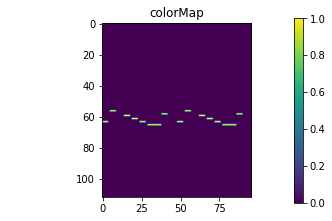

In [ ]:
#print(bar_list[0][0],bar_matrix_list[0][0],bar_matrix_list2[0][0]) 큰 의미 없다
import numpy as np
import matplotlib.pyplot as plt

H = bar_matrix_list2[0][0]

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

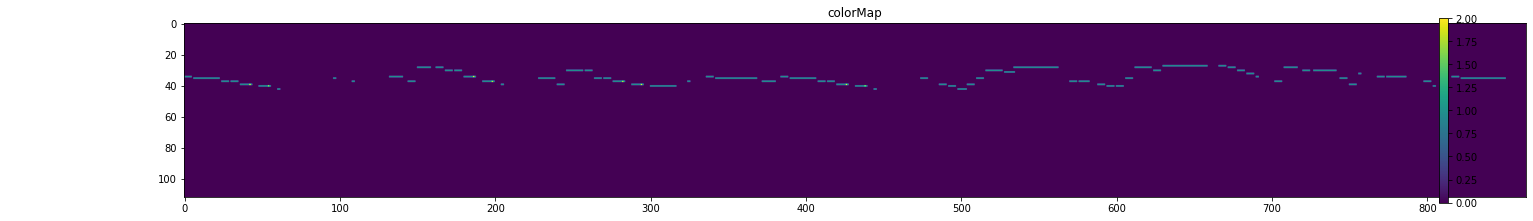

In [ ]:
tot=bar_matrix_list2[2]
H=bar_matrix_list2[2][0]
for i in range(1,len(tot)):
  a=bar_matrix_list2[2][i]
  H=np.concatenate((H,a),axis=1)
  
fig = plt.figure(figsize=(30, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
#위 for문 없이 돌리면 1 bar만 나옴

In [ ]:
def bar_to_contour(bar,one_bar_number,starting_number,j):
  contour=[]
  pitch_change_list=[]
  duration_list=[]
  real_pitch_list=[]
  real_time_list=[]
  real_duration_list=[]
  now_pitch=1000
  first_time=starting_number+one_bar_number*j
  a=0
  for lists in bar:
    if(a!=0): 
      real_time_list.append(lists[0]-now_rhythm)
    now_rhythm=lists[0]
    a+=1
    if (first_time*1.001<lists[0]):#smoothing for case like first time=5.00001, lists[0]=5.0000..
      resting_time=lists[0]-first_time
      duration_list.append(resting_time)
      first_time=lists[0]
      pitch_change_list.append('Rest')
    if (now_pitch==1000):
      pitch_change_list.append('Starting_Point')
      real_pitch_list.append('Starting_Point')
      real_duration_list.append(lists[3])
      duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      a+=1
    else:
      pitch_change=lists[1]-now_pitch
      pitch_change_list.append(str(pitch_change))#나중에 int로 바꿔쓸 것. 자료형 터지는거 때문에 우선 스트링.
      duration_list.append(lists[3])
      real_duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      real_pitch_list.append(str(pitch_change))
  if (first_time*1.001<starting_number+one_bar_number*(j+1)):
    pitch_change_list.append('Rest')#마지막 Rest
    duration_list.append(starting_number+one_bar_number*(j+1)-first_time)
  if(len(bar)!=0):
    real_time_list.append(starting_number+one_bar_number*(j+1)-now_rhythm)
  contour.append(pitch_change_list)
  contour.append(duration_list)
  contour.append(real_pitch_list)
  contour.append(real_time_list)
  contour.append(real_duration_list)
  #something
  return contour



Plot에서 중요한것은 Y-Axis의 0~112의 숫자가 Note의 반대 성향을 가진다는 것이다.(숫자가 커질수록 Note의 높이가 낮아진다.) 이는 PianoRoll을 이미지 처럼 사용하는 과정에서, 직관적인 학습이 가능하도록 이와 같이 구현한 것이다.

In [ ]:
bar_contour_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    contour=bar_to_contour(bar,one_bar_number_list[i],starting_number_list[i],j)
    bar_contour_list[i][j]=contour


bar_contour_list : 중간과정
bar_matrix_list2 : 아마 학습에 사용하게 될 Matrix의 List
bar_label_list : 학습에 사용하게 될 Label의 List

In [ ]:
print(bar_contour_list[0][0])


[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest', '-5.0', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', '-5.0', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5], [0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25]]


In [ ]:
for contours in bar_contour_list[11]:
  print(contours)
print(csvfilenames[11])
print(jsonlist[11])

[['Starting_Point', 'Rest', '-8.0', '3.0', 'Rest', '5.0', 'Rest', '-9.0', '1.0'], [0.16666666666666666, 0.08333333333333334, 0.125, 0.08333333333333331, 0.041666666666666685, 0.16666666666666663, 3.0833333333333335, 0.125, 0.16666666666666607], ['Starting_Point', '-8.0', '3.0', '5.0', '-9.0', '1.0'], [0.25, 0.125, 0.125, 3.25, 0.125, 0.125], [0.16666666666666666, 0.125, 0.08333333333333331, 0.16666666666666663, 0.125, 0.16666666666666607]]
[['Starting_Point', 'Rest'], [0.125, 3.875], ['Starting_Point'], [4.0], [0.125]]
[['Starting_Point', '-9.0', '1.0', '8.0', '-12.0', 'Rest'], [0.125, 0.125, 0.16666666666666607, 0.125, 0.16666666666666607, 3.291666666666668], ['Starting_Point', '-9.0', '1.0', '8.0', '-12.0'], [0.125, 0.125, 0.125, 0.125, 3.5], [0.125, 0.125, 0.16666666666666607, 0.125, 0.16666666666666607]]
[['Starting_Point', '-9.0', '1.0', '3.0', 'Rest', '5.0', 'Rest', '0.0', 'Rest', '-3.0', 'Rest'], [0.125, 0.125, 0.125, 0.08333333333333215, 0.04166666666666785, 0.125, 2.875, 0.125

In [ ]:
#최대한 많고 깔끔한 조건문을 사용하여 Skill들을 정의해볼 것. Multilabel Classification의 가능성이 있다.
"""
Skill들의 음악학적인 특성 & 계산적인 특성을 적는 곳
'resting' : 포함하는 음이 0 또는 1개인 경우 resting으로 정의. 다른 Skill들은 겹칠 수 있으나 이 skill이 Label될 경우 그냥 resting 고정이다.
즉, Skilling Labeling은 'resting'이 아닌 경우에 진행된다.
'repeating' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 전부 같은 음일 경우 repeating으로 정의
'up_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping up 또는 같은 음, 즉 반음기준 3Note 이하로 상승하는 형태일 경우 up_steping으로 정의
'down_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping down 또는 같은 음, 즉 반음기준 3Note 이하로 하강하는 형태일 경우 down_steping으로 정의
'up_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping up, 즉 반음기준 3Note 이상으로 상승하는 형태일 경우 up_leaping으로 정의
'down_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping down, 즉 반음기준 3Note 이상으로 하강하는 형태일 경우 down_leaping으로 정의
3Note에서 겹치는게 맞다. Multilabel Classification을 고안 중이기 때문.
'steping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 2Note 이하의 상승과 하강을 반복하는 형태일 경우 steping_twisting으로 정의
'leaping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 3Note 이상의 상승과 하강을 반복하는 형태일 경우 leaping_twisting으로 정의
'fast_rhythm' : 1 bar 내에 음이 9개 이상인 경우 fast_rhythm으로 정의.
'One_rhythm' :  모든 음이 지닌 연주의 real_time, 즉 음이 울리고 다음 음이 나올때 까지의 시간이 같으면 One_rhythm으로 정의
'triplet' : real_time기반해서 triplet이 존재하면(Note 3개) triplet으로 정의
'Staccato' : real_Duration_Time 기반해서 n% 이상의 음의 Duration이 0.16667(최소단위*4임)보다 작으면(매우 짧으면) Staccato로 정의
'continuing_rhythm' : pitch_change_list에서 'Rest'의 비율이 25퍼센트 이하면 continuing_rhythm으로 정의
첫 음 제외 실 음의 75%를 기준으로 잡는다.
5개 이상의 음이 있다면 1개를 제외하고 전부 조건에 맞아야하고,
9개 이상의 음이 있다면 2개를 제외하고 전부 조건에 맞아야하고...
4개 이하는 다 맞아야 한다.
ex) CDEF -> up_steping, CDED -> None, CDEFD-> up_steping.
다만 Leaping에 대해서는 많이 후해질 것 같다. 거의 50%가까이..?  
"""

"""
예시로는..
contour[0] = ['Starting_Point', 'Rest', '4.0', '1.0', 'Rest', '2.0', 'Rest', '-7.0', 'Rest'] Note pitch의 변화를 쉼표를 포함하여 의미한다.
contour[1] = [0.83333, 0.16666999999999987, 0.5, 0.33333, 0.16666999999999987, 0.8333299999999999, 0.16666999999999987, 0.75, 0.25] Duration을 쉼표를 포함하여 의미한다.
contour[2] = ['Starting_Point', '4.0', '1.0', '2.0', '-7.0'] note pitch의 변화를 의미한다.
contour[3] = [1.0, 0.5, 0.5, 1.0, 1.0] 한 음의 실 연주시간을 의미한다.(다음 음이 나올때 까지의 시간)
contour[4] = [0.83333, 0.5, 0.33333, 0.8333299999999999, 0.75] Duration을 의미한다.
"""
def is_repeating(contour_list,exception_range):
  boolean_repeating=0
  non_repeat=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if(elements != '0.0'):
        non_repeat+=1
  if (non_repeat<=exception_range):
    boolean_repeating=1
  return boolean_repeating

def is_up_steping(contour_list,exception_range):
  balancing_param=1
  boolean_up_steping=0
  non_step_up=0
  now_step_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_up==0):
        if (float(elements)<0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
      else:
        if(float(elements)<-0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
  if(non_step_up<=exception_range+balancing_param):
    boolean_up_steping=1
  return boolean_up_steping

def is_down_steping(contour_list,exception_range):
  boolean_down_steping=0
  balancing_param=0
  non_step_down=0
  now_step_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_down==0):
        if (float(elements)>-0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
      else:
        if(float(elements)>0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
  if(non_step_down<=exception_range+balancing_param):
    boolean_down_steping=1
  return boolean_down_steping

def is_up_leaping(contour_list,exception_range):
  boolean_up_leaping=0
  non_leap_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)<3.5):
        non_leap_up+=1
  if (non_leap_up<=exception_range+1):
    boolean_up_leaping=1
  return boolean_up_leaping

def is_down_leaping(contour_list,exception_range):
  boolean_down_leaping=0
  non_leap_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)>-3.5):
        non_leap_down+=1
  if (non_leap_down<=exception_range+1):
    boolean_down_leaping=1
  return boolean_down_leaping

def is_leaping_twisting(contour_list,exception_range):
  boolean_leaping_twisting=0
  non_leap_twist=0
  balancing_param=1
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (3.5<float(elements)):
          now_dir=1
        elif (float(elements) <-3.5):
          now_dir=-1
        else:
          non_leap_twist+=1
      elif (now_dir==1):
        if (float(elements) <-3.5):
          now_dir=-1
        else:
          now_dir=0
          non_leap_twist+=1
      elif (now_dir==-1):
        if (3.5<float(elements)):
          now_dir=1
        else:
          now_dir=0
          non_leap_twist+=1
  if(non_leap_twist<=exception_range+balancing_param):
    boolean_leaping_twisting=1
  return boolean_leaping_twisting

def is_steping_twisting(contour_list,exception_range):
  boolean_steping_twisting=0
  non_step_twist=0
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        elif (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          non_step_twist+=1
      elif (now_dir==1):
        if (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          now_dir=0
          non_step_twist+=1
      elif (now_dir==-1):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        else:
          now_dir=0
          non_step_twist+=1
  if(non_step_twist<=exception_range):
    boolean_steping_twisting=1
  return boolean_steping_twisting

def is_one_rhythm(contour_list,exception_range):
  boolean_one_rhythm=0
  non_same_rhythm=0

  first_rhythm=contour_list[0]
  for rhythms in contour_list:
    if (rhythms != first_rhythm):
      non_same_rhythm=1
  boolean_one_rhythm=1-non_same_rhythm
  return boolean_one_rhythm

def is_triplet(contour_list,exception_range):
  boolean_triplet=0
  now_triplet=0
  for rhythms in contour_list:
    rhythms=float(rhythms)
    if (rhythms%0.015625>0.001):
      if(now_triplet==1):
        boolean_triplet=1
      now_triplet+=1
    else:
      now_triplet=0
      
  return boolean_triplet

def is_staccato(contour_list,exception_range):
  boolean_staccato=0
  ranges=len(contour_list)//2
  staccato_num=0
  for times in contour_list:
    if (times<0.2):
      staccato_num+=1
  if (staccato_num>=ranges):
    boolean_staccato=1
  return boolean_staccato

def is_continuing_rhythm(contour_list):
  boolean_continuing_rhythm=0
  length=len(contour_list)
  rest_num=0
  for elements in contour_list:
    if (elements=='Rest'):
      rest_num+=1
  if (rest_num<=0.5):
    boolean_continuing_rhythm=1
  return boolean_continuing_rhythm

def contour_to_label(contour):
  labels=[]
  totnum=len(contour[2]) #실 음의 갯수이다.
  exception_range=(totnum-1)//4
  exception_range2=(totnum-1)//3
  if (len(contour[2])<2.5):
    labels.append('resting')
    return labels
  else:
    if (is_repeating(contour[2],exception_range2)):
      labels.append('repeating')

    if (is_up_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('up_steping')

    if (is_down_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('down_steping')

    if (is_up_leaping(contour[2],exception_range2)):
      labels.append('up_leaping')
    
    if (is_down_leaping(contour[2],exception_range2)):
      labels.append('down_leaping')

    if (is_steping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('steping_twisting')

    if (is_leaping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('leaping_twisting')

    if (len(contour[2])>8.5):
      labels.append('fast_rhythm')

    if (is_one_rhythm(contour[3],exception_range)):
      labels.append('One_rhythm')

    if (is_triplet(contour[3],exception_range2)):
      labels.append('triplet')

    if (is_staccato(contour[1],exception_range2)):
      labels.append('staccato')  

    if (is_continuing_rhythm(contour[0])):
      labels.append('continuing_rhythm')  

  if (len(labels)==0):
    labels.append('no skills')
     
  #something
  return labels

In [ ]:
bar_label_list=copy.deepcopy(bar_contour_list)
for i,songs in enumerate(bar_contour_list):
  for j,contour in enumerate(songs):
    label=contour_to_label(contour) 
    bar_label_list[i][j]=label

In [ ]:
for j in range(len(bar_label_list[0])):
  print(bar_label_list[0][j])
  print(bar_contour_list[0][j])
print(csvfilenames[0])  


['fast_rhythm']
[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest', '-5.0', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', '-5.0', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5], [0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25]]
['fast_rhythm']
[['Starting_Point', '7.0', 'Rest', '-7.0', '0.0', '0.0', '0.0', '0.0', '-7.0', '7.0', '-7.0', '4.0', '3.0', '3.0', '-5.0'], [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5], ['Starting_Point', '7.0', '-7.0', '0.0', '0.0', '0.0', '0.0', '-7.0', '7.0', '-7.0', '4.0', '3.0', '3.0', '-5.0'], [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5], [0.25, 0.25, 0.25

[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest', '-5.0', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', '-5.0', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5], [0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25]]
['fast_rhythm']
[[ 0.   48.   48.    0.25  0.  ]
 [ 0.25 55.   55.    0.25  0.  ]
 [ 0.75 52.   52.    0.25  0.  ]
 [ 1.   50.   50.    0.25  0.  ]
 [ 1.25 48.   48.    0.25  0.  ]
 [ 1.5  46.   46.    0.5   0.  ]
 [ 2.   53.   53.    0.25  0.  ]
 [ 2.5  48.   48.    0.25  0.  ]
 [ 2.75 55.   55.    0.25  0.  ]
 [ 3.25 52.   52.    0.25  0.  ]
 [ 3.5  50.   50.    0.25  0.  ]
 [ 3.75 48.   48.    0.25  0.  ]
 [ 4.   46.   46.    0.5   0.  ]
 [ 4.5  53

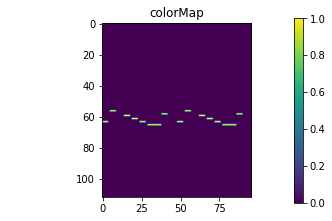

In [ ]:
#Summary
print(bar_contour_list[0][0])
print(bar_label_list[0][0])
print(bar_list[0][0])

H=bar_matrix_list2[0][0]
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
#위 for문 없이 돌리면 1 bar만 나옴
#matrix_list2를 CNN하되 라벨을 label로 가져가면 될듯 bar_label_list[i][j]는 i번째곡의 j번째 bar를 의미하고, 나머지도 같다.

In [ ]:
all_matrix=[]
all_labels=[]
for songs in bar_label_list:
  for label in songs:
    label=np.array(label)
    all_labels.append(label)
for songs in bar_matrix_list2:
  for matrix in songs:
    matrix=matrix.reshape(112,96,1)
    all_matrix.append(matrix)


In [ ]:
print(len(all_matrix),len(all_labels))

90341 90341


In [ ]:
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():
  if tfback._LOCAL_DEVICES is None:
    devices = tf.config.list_logical_devices()
    tfback._LOCAL_DEVICES = [x.name for x in devices]
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
train_matrix=np.array(all_matrix[:75000])
train_label=np.array(all_labels[:75000])

In [ ]:
all_matrix=all_matrix[75000:]
all_labels=all_labels[75000:]

In [ ]:
valid_matrix=np.array(all_matrix[:15000])
valid_label=np.array(all_labels[:15000])
test_matrix=np.array(all_matrix[15000:])
test_label=np.array(all_labels[15000:])#어쩌면 쓸수도?
mlb=MultiLabelBinarizer()
mlb.fit([['no skills','resting','repeating','up_steping','down_steping','up_leaping','down_leaping','steping_twisting','leaping_twisting','fast_rhythm','One_rhythm','triplet','staccato','continuing_rhythm']])
train_label2=mlb.transform(train_label)
valid_label2=mlb.transform(valid_label)
test_label2=mlb.transform(test_label)


In [ ]:
print(train_matrix.shape)
print(train_label2)
print(valid_matrix.shape)

(75000, 112, 96, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
(15000, 112, 96, 1)


In [ ]:
import tensorflow.keras.applications
from keras import regularizers
from keras.applications import VGG16
from keras.applications import resnet50
from keras import layers
def residual_block(filter, input, add=True):
    layer_1 = keras.layers.Conv2D(filters=filter//4, kernel_size=(1, 1), data_format="channels_first")(input)
    layer_2 = keras.layers.Conv2D(filters=filter//4, kernel_size=(3, 3), padding='same', data_format="channels_first", kernel_regularizer=keras.regularizers.l2(0.001))(layer_1)
    layer_2 = keras.layers.BatchNormalization()(layer_2)
    layer_2 = keras.layers.ReLU()(layer_2)
    layer_3 = keras.layers.Conv2D(filters=filter, kernel_size=(1, 1), data_format="channels_first")(layer_2)
    layer_3 = keras.layers.BatchNormalization()(layer_3)
    if add:
        layer_3 = keras.layers.add([input, layer_3])
    layer_3 = keras.layers.ReLU()(layer_3)
    return layer_3
def make_model():
  with tf.device('/gpu:0'):
    input_layer = keras.Input(shape=(112, 96, 1))
    layer_1 = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', data_format="channels_first")(input_layer)
    block_1 = residual_block(64, layer_1)
    block_2 = residual_block(64, block_1)
    #block_3 = residual_block(64, block_2)
    pooling_layer = keras.layers.MaxPool2D((2, 2),padding='same', data_format="channels_first")(block_1)
    block_4 = residual_block(128, pooling_layer, add=False)
    block_5 = residual_block(128, block_4)
    #block_6 = residual_block(128, block_5)
    pooling_layer2 = keras.layers.MaxPool2D(padding='same',pool_size=(2, 2), data_format="channels_first")(block_4)
    block_7 = residual_block(256, pooling_layer2, add=False)
    block_8 = residual_block(256, block_7)
    block_9 = residual_block(256, block_8)
    #pooling_layer4 = keras.layers.MaxPool2D(pool_size=(2, 2), data_format="channels_first")(block_7)
    #block_10 = residual_block(256, pooling_layer4)
    #block_11 = residual_block(512, block_10)
    pooling_layer3 = keras.layers.AvgPool2D(padding='same',pool_size=(8, 8), data_format="channels_first")(block_7)
    last_layer = keras.layers.Flatten()(pooling_layer3)
    last_layer = keras.layers.Dropout(0.4)(last_layer)
    last_layer = keras.layers.Dense(14, activation="sigmoid")(last_layer)
    return keras.models.Model(inputs=input_layer, outputs=last_layer)
def make_classifier():
  with tf.device('/gpu:0'):
    classifier = Sequential()
    classifier.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same',
                  activation='relu',
                  input_shape=(112,96,1)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.advanced_activations.LeakyReLU(alpha=0.01))
    classifier.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    classifier.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    classifier.add(layers.Conv2D(256, (2, 2), padding='same'))
    classifier.add(layers.advanced_activations.LeakyReLU(alpha=0.01))
    classifier.add(layers.MaxPooling2D(pool_size=(2, 2)))
    classifier.add(layers.Flatten())
    classifier.add(layers.Dropout(0.25))
    classifier.add(Dense(14, activation='sigmoid'))
  return classifier

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_path = '/content/drive/My Drive/models/' + 'deeperppddbest.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
callbacks = [cb_checkpoint]

In [ ]:
classifier=make_model()
classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='binary_crossentropy'
  ), optimizer='adam', metrics=['accuracy'])

classifier.fit(
      train_matrix,train_label2,batch_size=256,
      epochs=500,
      validation_data=(valid_matrix,valid_label2),
      callbacks=callbacks,
  )

Train on 75000 samples, validate on 15000 samples
Epoch 1/500
75000/75000 [==============================] - 12s 158us/step - loss: 0.4180 - accuracy: 0.8900 - val_loss: 0.6652 - val_accuracy: 0.8259

Epoch 00001: val_accuracy did not improve from 0.93757
Epoch 2/500
75000/75000 [==============================] - 10s 140us/step - loss: 0.3578 - accuracy: 0.9139 - val_loss: 0.4069 - val_accuracy: 0.8889

Epoch 00002: val_accuracy did not improve from 0.93757
Epoch 3/500
75000/75000 [==============================] - 10s 139us/step - loss: 0.3420 - accuracy: 0.9223 - val_loss: 0.3397 - val_accuracy: 0.9242

Epoch 00003: val_accuracy did not improve from 0.93757
Epoch 4/500
75000/75000 [==============================] - 10s 140us/step - loss: 0.3328 - accuracy: 0.9273 - val_loss: 0.3346 - val_accuracy: 0.9265

Epoch 00004: val_accuracy did not improve from 0.93757
Epoch 5/500
75000/75000 [==============================] - 11s 140us/step - loss: 0.3262 - accuracy: 0.9313 - val_loss: 0.3252

In [ ]:
testresult=classifier.predict(test_matrix)

In [ ]:
classnum={}
testnum={}
resultmat=[]
for i in range(len(testresult)):
  eval_result=[0 for i in range(14)]
  class_num=np.count_nonzero(test_label2[i]==1)
  classidx=(-testresult[i]).argsort()[:class_num]
  for j in classidx:
    eval_result[j]=1
  resultmat.append(eval_result)
resultmat=np.array(resultmat)
testidx=mlb.inverse_transform(resultmat)
classidx=mlb.inverse_transform(test_label2)
for i in range(len(testidx)):  
  print(testidx[i], classidx[i])
  for classes in classidx[i]:
    if (classes not in classnum):
      classnum[classes]=1
    else:
      classnum[classes]+=1
  for classes in testidx[i]:
    if (classes not in testnum):
      testnum[classes]=1
    else:
      testnum[classes]+=1
print(classnum, testnum)

('leaping_twisting', 'up_steping') ('leaping_twisting', 'up_steping')
('One_rhythm', 'down_leaping', 'leaping_twisting', 'staccato', 'up_leaping') ('One_rhythm', 'down_leaping', 'leaping_twisting', 'staccato', 'up_leaping')
('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping') ('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping')
('leaping_twisting', 'up_leaping') ('leaping_twisting', 'up_leaping')
('One_rhythm', 'down_leaping', 'leaping_twisting') ('One_rhythm', 'down_leaping', 'leaping_twisting')
('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping') ('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping')
('One_rhythm', 'down_leaping', 'leaping_twisting') ('One_rhythm', 'down_leaping', 'leaping_twisting')
('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping') ('One_rhythm', 'down_leaping', 'leaping_twisting', 'up_leaping')
('leaping_twisting', 'up_steping') ('leaping_twisting', 'up_steping')
('One_rhythm', 'down_leaping', 'leaping_tw